In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from PIL import Image
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
train_transform = transforms.Compose([
        transforms.ToTensor()
    ])

test_transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [3]:
root = r"C:\Users\omer-\Desktop\dogs"
#torch.manual_seed(123)

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)
classes = train_data.classes

Label: [1 2 1 1 1 2 2 2 1 0]
Class: husky pug husky husky husky pug pug pug husky golden


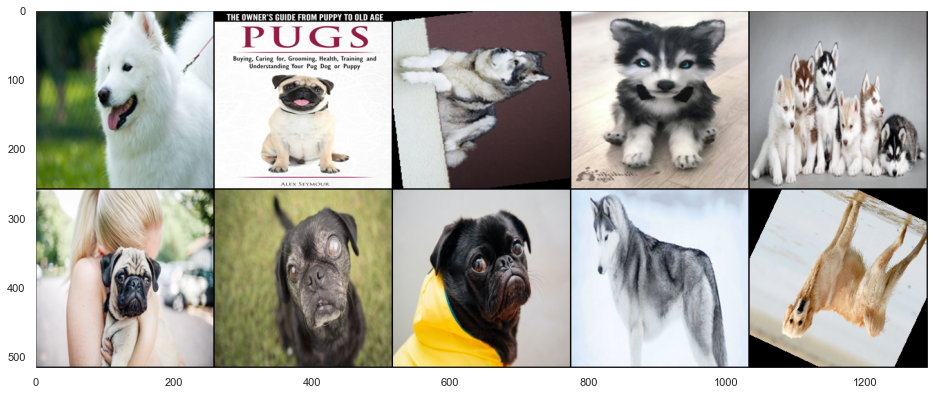

In [4]:
for images,labels in train_loader: 
    break

print('Label:', labels.numpy())
print('Class:', *np.array([classes[i] for i in labels]))

img = make_grid(images, nrow=5)

plt.figure(figsize=(16,10))
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)));
plt.grid()

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(62*62*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 62*62*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [9]:
#torch.manual_seed(360531757149500)
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=61504, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [10]:
begin = time.time()

epochs =5
train_batch_size = train_loader.batch_size
test_batch_size = test_loader.batch_size
train_data_size = len(train_data)
test_data_size = len(test_data)

train_losses = []
test_losses = []
train_corrects = []
test_corrects = []

for i in (range(epochs)):
    train_correct = 0
    test_correct = 0
    total_train = 0
    total_test = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        total_train += X_train.size()[0]
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b%40 == 0 and b!=0:
            print("Epoch :{0}\t{1}/{2}\tLoss : {3:.4f}\tAccuracy : % {4:.2f} "\
                  .format(i,b*train_batch_size,train_data_size,loss.item(),train_correct.item()*100/total_train))
    
    train_losses.append(loss)
    train_corrects.append(train_correct)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            total_test += X_test.size()[0]
            y_val = model(X_test)
            
            predicted = torch.max(y_val.data, 1)[1] 
            test_correct += (predicted == y_test).sum()
            if b%X_test.size()[0]==0 and b!=0:
                print("Validation Accuracy : % {0:.2f}".format(test_correct.item()*100/total_test))
                print("-------------------------------------------------------------------")
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_corrects.append(test_correct)

print("Elapsed Time: {0:.0f} seconds".format((time.time()-begin)))

Epoch :0	400/1989	Loss : 1.3042	Accuracy : % 38.54 
Epoch :0	800/1989	Loss : 1.0048	Accuracy : % 41.23 
Epoch :0	1200/1989	Loss : 1.1033	Accuracy : % 46.03 
Epoch :0	1600/1989	Loss : 0.5291	Accuracy : % 49.44 
Validation Accuracy : % 60.91
-------------------------------------------------------------------
Epoch :1	400/1989	Loss : 1.0737	Accuracy : % 61.22 
Epoch :1	800/1989	Loss : 0.8449	Accuracy : % 61.36 
Epoch :1	1200/1989	Loss : 0.9991	Accuracy : % 61.90 
Epoch :1	1600/1989	Loss : 0.8892	Accuracy : % 63.79 
Validation Accuracy : % 56.36
-------------------------------------------------------------------
Epoch :2	400/1989	Loss : 0.6953	Accuracy : % 69.27 
Epoch :2	800/1989	Loss : 0.6720	Accuracy : % 69.38 
Epoch :2	1200/1989	Loss : 0.5646	Accuracy : % 70.66 
Epoch :2	1600/1989	Loss : 0.3381	Accuracy : % 72.17 
Validation Accuracy : % 58.18
-------------------------------------------------------------------
Epoch :3	400/1989	Loss : 0.4242	Accuracy : % 79.76 
Epoch :3	800/1989	Loss :

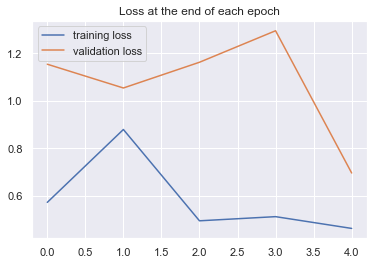

In [11]:
plt.plot([i.item() for i in train_losses], label='training loss')
plt.plot([i.item() for i in test_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

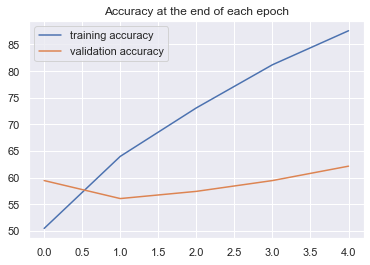

In [12]:
plt.plot([i.item()/len(train_data)*100 for i in train_corrects], label='training accuracy')
plt.plot([i.item()/len(test_data)*100 for i in test_corrects], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Yeni bir foto denemek için

In [13]:
def deneme(path):
    img = Image.open(path)
    if np.array(img).shape[2] ==4:
        img =  Image.fromarray(np.array(img)[:,:,:3])
    X_test = test_transform(img.resize((256,256))).to(device)
    with torch.no_grad():
          
        y_val = model(X_test[None,:])
        predicted = torch.max(y_val.data, 1)[1] 
    return train_data.classes[predicted.item()]

In [14]:
deneme(r"C:\Users\omer-\Desktop\husky.png")

'husky'

In [15]:
deneme(r"C:\Users\omer-\Desktop\pug.png")

'pug'

In [16]:
deneme(r"C:\Users\omer-\Desktop\pug2.png")

'pug'

In [17]:
deneme(r"C:\Users\omer-\Desktop\golden.jpg")

'golden'

# AlexNet

In [20]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

Using cache found in C:\Users\omer-/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
begin = time.time()

epochs = 5
train_batch_size = train_loader.batch_size
test_batch_size = test_loader.batch_size
train_data_size = len(train_data)
test_data_size = len(test_data)

train_losses = []
test_losses = []
train_corrects = []
test_corrects = []

for i in (range(epochs)):
    train_correct = 0
    test_correct = 0
    total_train = 0
    total_test = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        total_train += X_train.size()[0]
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b%40 == 0 and b!=0:
            print("Epoch :{0}\t{1}/{2}\tLoss : {3:.4f}\tAccuracy : % {4:.2f} "\
                  .format(i,b*train_batch_size,train_data_size,loss.item(),train_correct.item()*100/total_train))
    
    train_losses.append(loss)
    train_corrects.append(train_correct)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            total_test += X_test.size()[0]
            y_val = model(X_test)
            
            predicted = torch.max(y_val.data, 1)[1] 
            test_correct += (predicted == y_test).sum()
            if b%X_test.size()[0]==0 and b!=0:
                print("Validation Accuracy : % {0:.2f}".format(test_correct.item()*100/total_test))
                print("-------------------------------------------------------------------")
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_corrects.append(test_correct)

print("Elapsed Time: {0:.0f} seconds".format((time.time()-begin)))

Epoch :0	400/1989	Loss : 1.1633	Accuracy : % 33.17 
Epoch :0	800/1989	Loss : 1.0694	Accuracy : % 35.68 
Epoch :0	1200/1989	Loss : 1.0833	Accuracy : % 36.12 
Epoch :0	1600/1989	Loss : 1.0716	Accuracy : % 36.09 
Validation Accuracy : % 34.55
-------------------------------------------------------------------
Epoch :1	400/1989	Loss : 1.0593	Accuracy : % 39.76 
Epoch :1	800/1989	Loss : 1.1275	Accuracy : % 38.27 
Epoch :1	1200/1989	Loss : 1.1023	Accuracy : % 37.52 
Epoch :1	1600/1989	Loss : 1.0598	Accuracy : % 36.21 
Validation Accuracy : % 33.64
-------------------------------------------------------------------
Epoch :2	400/1989	Loss : 0.9774	Accuracy : % 41.95 
Epoch :2	800/1989	Loss : 1.0730	Accuracy : % 39.63 
Epoch :2	1200/1989	Loss : 1.1853	Accuracy : % 38.93 
Epoch :2	1600/1989	Loss : 1.0351	Accuracy : % 37.27 
Validation Accuracy : % 34.55
-------------------------------------------------------------------
Epoch :3	400/1989	Loss : 1.0898	Accuracy : % 38.29 
Epoch :3	800/1989	Loss :

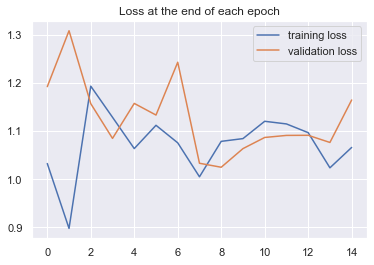

In [22]:
plt.plot([i.item() for i in train_losses], label='training loss')
plt.plot([i.item() for i in test_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

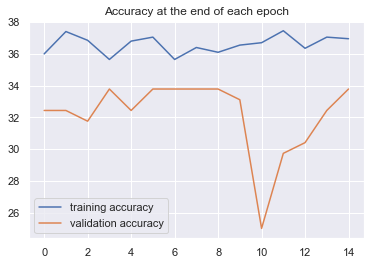

In [23]:
plt.plot([i.item()/len(train_data)*100 for i in train_corrects], label='training accuracy')
plt.plot([i.item()/len(test_data)*100 for i in test_corrects], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# Resnet

In [24]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

Using cache found in C:\Users\omer-/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
begin = time.time()

epochs = 5
train_batch_size = train_loader.batch_size
test_batch_size = test_loader.batch_size
train_data_size = len(train_data)
test_data_size = len(test_data)

train_losses = []
test_losses = []
train_corrects = []
test_corrects = []

for i in (range(epochs)):
    train_correct = 0
    test_correct = 0
    total_train = 0
    total_test = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        total_train += X_train.size()[0]
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b%40 == 0 and b!=0:
            print("Epoch :{0}\t{1}/{2}\tLoss : {3:.4f}\tAccuracy : % {4:.2f} "\
                  .format(i,b*train_batch_size,train_data_size,loss.item(),train_correct.item()*100/total_train))
    
    train_losses.append(loss)
    train_corrects.append(train_correct)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            total_test += X_test.size()[0]
            y_val = model(X_test)
            
            predicted = torch.max(y_val.data, 1)[1] 
            test_correct += (predicted == y_test).sum()
            if b%X_test.size()[0]==0 and b!=0:
                print("Validation Accuracy : % {0:.2f}".format(test_correct.item()*100/total_test))
                print("-------------------------------------------------------------------")
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_corrects.append(test_correct)

print("Elapsed Time: {0:.0f} seconds".format((time.time()-begin)))

Epoch :0	400/1989	Loss : 0.9725	Accuracy : % 86.83 
Epoch :0	800/1989	Loss : 0.0953	Accuracy : % 87.53 
Epoch :0	1200/1989	Loss : 0.6969	Accuracy : % 87.85 
Epoch :0	1600/1989	Loss : 0.0986	Accuracy : % 88.45 
Validation Accuracy : % 67.27
-------------------------------------------------------------------
Epoch :1	400/1989	Loss : 0.3660	Accuracy : % 88.54 
Epoch :1	800/1989	Loss : 0.0142	Accuracy : % 87.16 
Epoch :1	1200/1989	Loss : 0.2247	Accuracy : % 88.35 
Epoch :1	1600/1989	Loss : 0.3166	Accuracy : % 89.81 
Validation Accuracy : % 73.64
-------------------------------------------------------------------
Epoch :2	400/1989	Loss : 0.0871	Accuracy : % 95.12 
Epoch :2	800/1989	Loss : 0.3795	Accuracy : % 95.68 
Epoch :2	1200/1989	Loss : 0.0398	Accuracy : % 95.12 
Epoch :2	1600/1989	Loss : 0.0151	Accuracy : % 94.84 
Validation Accuracy : % 81.82
-------------------------------------------------------------------
Epoch :3	400/1989	Loss : 0.0059	Accuracy : % 98.05 
Epoch :3	800/1989	Loss :

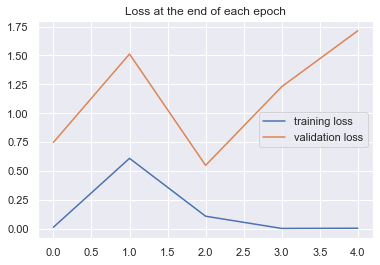

In [27]:
plt.plot([i.item() for i in train_losses], label='training loss')
plt.plot([i.item() for i in test_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

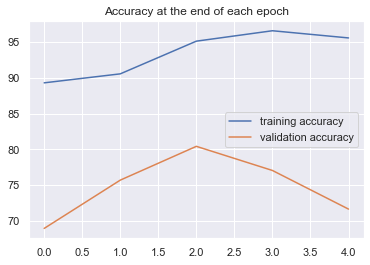

In [28]:
plt.plot([i.item()/len(train_data)*100 for i in train_corrects], label='training accuracy')
plt.plot([i.item()/len(test_data)*100 for i in test_corrects], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();